In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB2'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

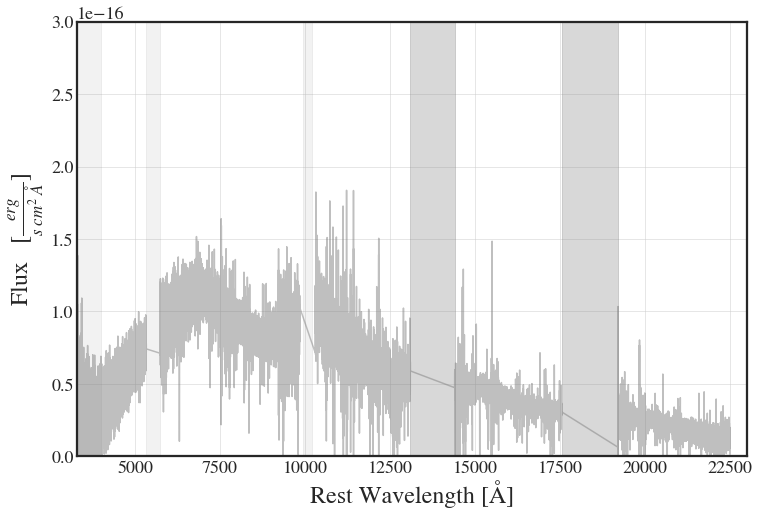

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [14]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, tau   , lam, vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3#*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    lam = v['lam0']
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, lam = lam)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [15]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [8]:
p = lmfit.Parameters()
OB = 'OB2'
with open("./data/%s_one_line_init.json"%OB, 'r') as infile:
    p.load(infile)

start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 0.1468217134475708


In [11]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=2.42), mi2.params['ve'], mi2.params['vphot']

(40.17787837357247,
 <Parameter 've', value=6.60018362959907, bounds=[0:10]>,
 <Parameter 'vphot', value=0.23987609358610124, bounds=[0:1]>)

In [10]:
mi2.params

name,value,initial value,min,max,vary
T,3885.62464,3950,2500.00000,7500.00000,True
N,2.9284e-29,2.7e-29,-inf,inf,True
vphot,0.23987609,0.248,0.00000000,1.00000000,True
vmax,0.27422810,0.28,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,1.59811106,1.5,0.00000000,20.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,6.60018363,6.6,0.00000000,10.0000000,True
occult,1.86718655,1.84,0.10000000,10.0000000,True
amp1,0.64712369,0.62,0.01000000,5.00000000,True


In [12]:
with open("./data/%s_one_line_1.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [36]:
p = lmfit.Parameters()
with open("./Data/%s_one_line_1.json"%OB, 'r') as infile:
    p.load(infile)

#p
#lum_dist_arr(p['N'],p['vphot'],n_days=2.45), p['ve'], p['vphot']
#p['ve'].value = 0.07
## OB2_1 : fixed ve = [0-0.2]
## OB2_2 : free  ve
p['cen1'].vary=True; p['cen2'].vary=True
p['sig1'].vary=True; p['sig2'].vary=True

p['lam1'].value = 10456

name,value,initial value,min,max,vary
T,3885.62464,3950,2500.00000,7500.00000,True
N,2.9284e-29,2.7e-29,-inf,inf,True
vphot,0.23987609,0.248,0.00000000,1.00000000,True
vmax,0.27422810,0.28,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,1.59811106,1.5,0.00000000,20.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,6.60018363,6.6,0.00000000,10.0000000,True
occult,1.86718655,1.84,0.10000000,10.0000000,True
amp1,0.64712369,0.62,0.01000000,5.00000000,True


In [39]:
pickle_in = open("./data/OB2/OB2_1_line_40x10000.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

#p['lam0'].value = 10400
p['cen2'].value = 2e-6
#p['lam0'].vary = False
p

name,value,standard error,relative error,initial value,min,max,vary
T,3952.22994,5.61727500,(0.14%),3885.6246410631175,2500.00000,7500.00000,True
N,2.6789e-29,2.4240e-31,(0.90%),2.9283508300679505e-29,-inf,inf,True
vphot,0.25563362,0.00124503,(0.49%),0.23987609358610124,0.00000000,1.00000000,True
vmax,0.28847466,0.00132381,(0.46%),0.2742280954961268,0.00000000,1.00000000,True
t0,212400.000,,(0.46%),212400,-inf,inf,False
tau,1.62592008,0.55485052,(34.13%),1.5981110581192914,0.00000000,20.0000000,True
vref,0.00000000,,(34.13%),0.0,0.00000000,1.00000000,False
ve,3.82593927,2.21515571,(57.90%),6.60018362959907,0.00000000,10.0000000,True
occult,1.97705386,0.09689492,(4.90%),1.867186552418812,0.10000000,10.0000000,True
amp1,0.77856414,0.06473883,(8.32%),0.64712368727546,0.01000000,5.00000000,True


#### Markov Chain Monto Carlo to sample distribution

In [41]:
mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 50 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=3000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 3000/3000 [44:55<00:00,  1.11it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [154.52338302 157.56351195 239.50366544 233.69857131 256.09466461
 311.32656103 264.53381291 265.92670763 287.05282279 182.2744374
 141.59688753 216.05005207 234.86563588 173.96739264]
Time elapsed [hours]: 0.7491982711686028


In [44]:
with open("./Data/OB2/OB2_2_line_50x3000.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile)

In [45]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3952.96793,2.53911302,(0.06%),3952.2299386619893,2500.00000,7500.00000,True
N,2.6774e-29,8.7797e-32,(0.33%),2.678880429450622e-29,-inf,inf,True
vphot,0.25641418,9.1866e-04,(0.36%),0.2556336239971362,0.00000000,1.00000000,True
vmax,0.29007352,9.9488e-04,(0.34%),0.28847465545178963,0.00000000,1.00000000,True
t0,212400.000,,(0.34%),212400,-inf,inf,False
tau,1.55208553,0.03045921,(1.96%),1.6259200843819528,0.00000000,20.0000000,True
vref,0.00000000,,(1.96%),0.0,0.00000000,1.00000000,False
ve,3.75153944,0.10811019,(2.88%),3.8259392699450694,0.00000000,10.0000000,True
occult,1.98893372,0.02573057,(1.29%),1.9770538560381206,0.10000000,10.0000000,True
amp1,0.78713695,0.01026527,(1.30%),0.7785641414798489,0.01000000,5.00000000,True


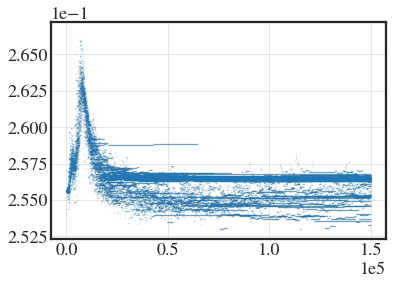

In [46]:
plt.scatter(np.arange(len(res2.flatchain['lam0'])), res2.flatchain['vphot'], s=0.1, alpha=0.1)

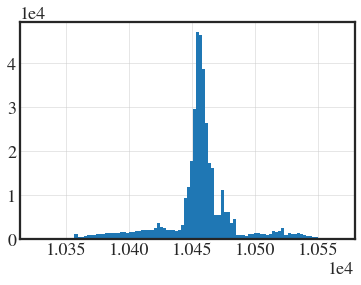

In [18]:
plt.hist(flat['lam0'], bins=100);

In [19]:
#with open("./Data/OB2/OB2_1_line_40x10000.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

In [77]:
#with open("./Data/OB2/OB2_3_peaks_filtered.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

In [19]:
p['ve']

<Parameter 've', value=0.11 (fixed), bounds=[0:1]>

In [9]:
# For loading previous runs... 

#pickle_in = open("./data/OB2/OB2_3_peaks_100walkers.pkl","rb")
#res2 = pickle.load(pickle_in)
#p = res2.params
#lum_dist_arr(p['N'],p['vphot'],n_days=2.42), p['ve'], p['vphot']

(43.04013546814999,
 <Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>,
 <Parameter 'vphot', value=0.24808001429652052 +/- 0.000521, bounds=[0:1]>)

In [30]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3952.22994,5.61727500,(0.14%),3885.6246410631175,2500.00000,7500.00000,True
N,2.6789e-29,2.4240e-31,(0.90%),2.9283508300679505e-29,-inf,inf,True
vphot,0.25563362,0.00124503,(0.49%),0.23987609358610124,0.00000000,1.00000000,True
vmax,0.28847466,0.00132381,(0.46%),0.2742280954961268,0.00000000,1.00000000,True
t0,212400.000,,(0.46%),212400,-inf,inf,False
tau,1.62592008,0.55485052,(34.13%),1.5981110581192914,0.00000000,20.0000000,True
vref,0.00000000,,(34.13%),0.0,0.00000000,1.00000000,False
ve,3.82593927,2.21515571,(57.90%),6.60018362959907,0.00000000,10.0000000,True
occult,1.97705386,0.09689492,(4.90%),1.867186552418812,0.10000000,10.0000000,True
amp1,0.77856414,0.06473883,(8.32%),0.64712368727546,0.01000000,5.00000000,True


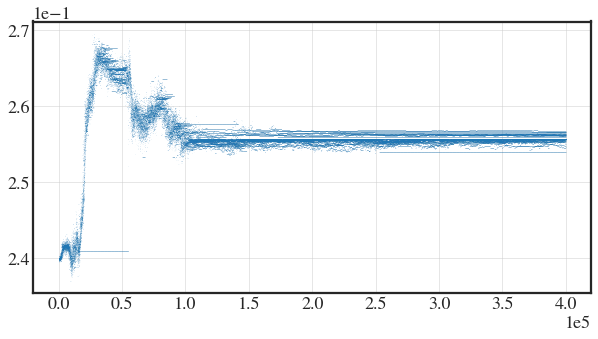

In [24]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.01, alpha=0.1) 


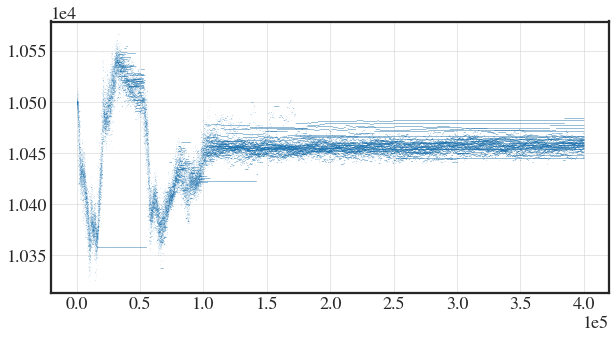

In [29]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['lam0'], s=0.01, alpha=0.1) 


45.77943457710481 45.63195876733708 45.94142315927114


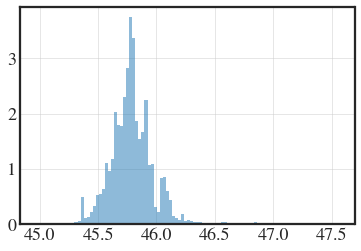

In [27]:
flat = res2.flatchain
#dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
#plt.hist(dl, bins=100, density=True, alpha=0.5); 
#print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
#plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(2000*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [62]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3907.81298,2.20307229,(0.06%),3901.684869313191,2500.00000,7500.00000,True
N,2.8767e-29,8.1691e-32,(0.28%),2.901530994172168e-29,-inf,inf,True
vphot,0.26417971,0.00128935,(0.49%),0.26494218465915764,0.00000000,1.00000000,True
vmax,0.29514813,7.2277e-04,(0.24%),0.29538359271367476,0.00000000,1.00000000,True
t0,212400.000,,(0.24%),212400,-inf,inf,False
tau,3.74541811,1.80193230,(48.11%),4.922574068875113,0.00000000,20.0000000,True
vref,0.00000000,,(48.11%),0.0,0.00000000,1.00000000,False
ve,8.58641653,1.33596675,(15.56%),7.077905243169155,0.00000000,10.0000000,True
occult,1.18166550,0.04975578,(4.21%),1.4956418766946291,0.10000000,10.0000000,True
amp1,0.59971709,0.01242183,(2.07%),0.5315972660162986,0.01000000,5.00000000,True


43.04702908840992 42.91479692531522 43.18370582478217


NameError: name 'nwalkers' is not defined

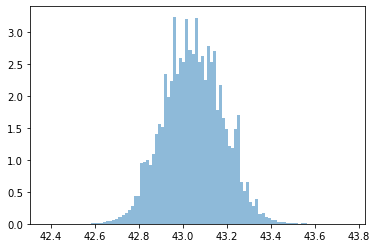

In [10]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(800*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [32]:
0.00980*c*1e-3/44.9, 0.00980*c*1e-3/45.3

(65.47884187082406, 64.90066225165563)

In [23]:
np.shape(flat['T'][:,25*1000:])

(1250000,)

In [39]:
np.shape(np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]))

(7, 900000)

In [11]:
import corner

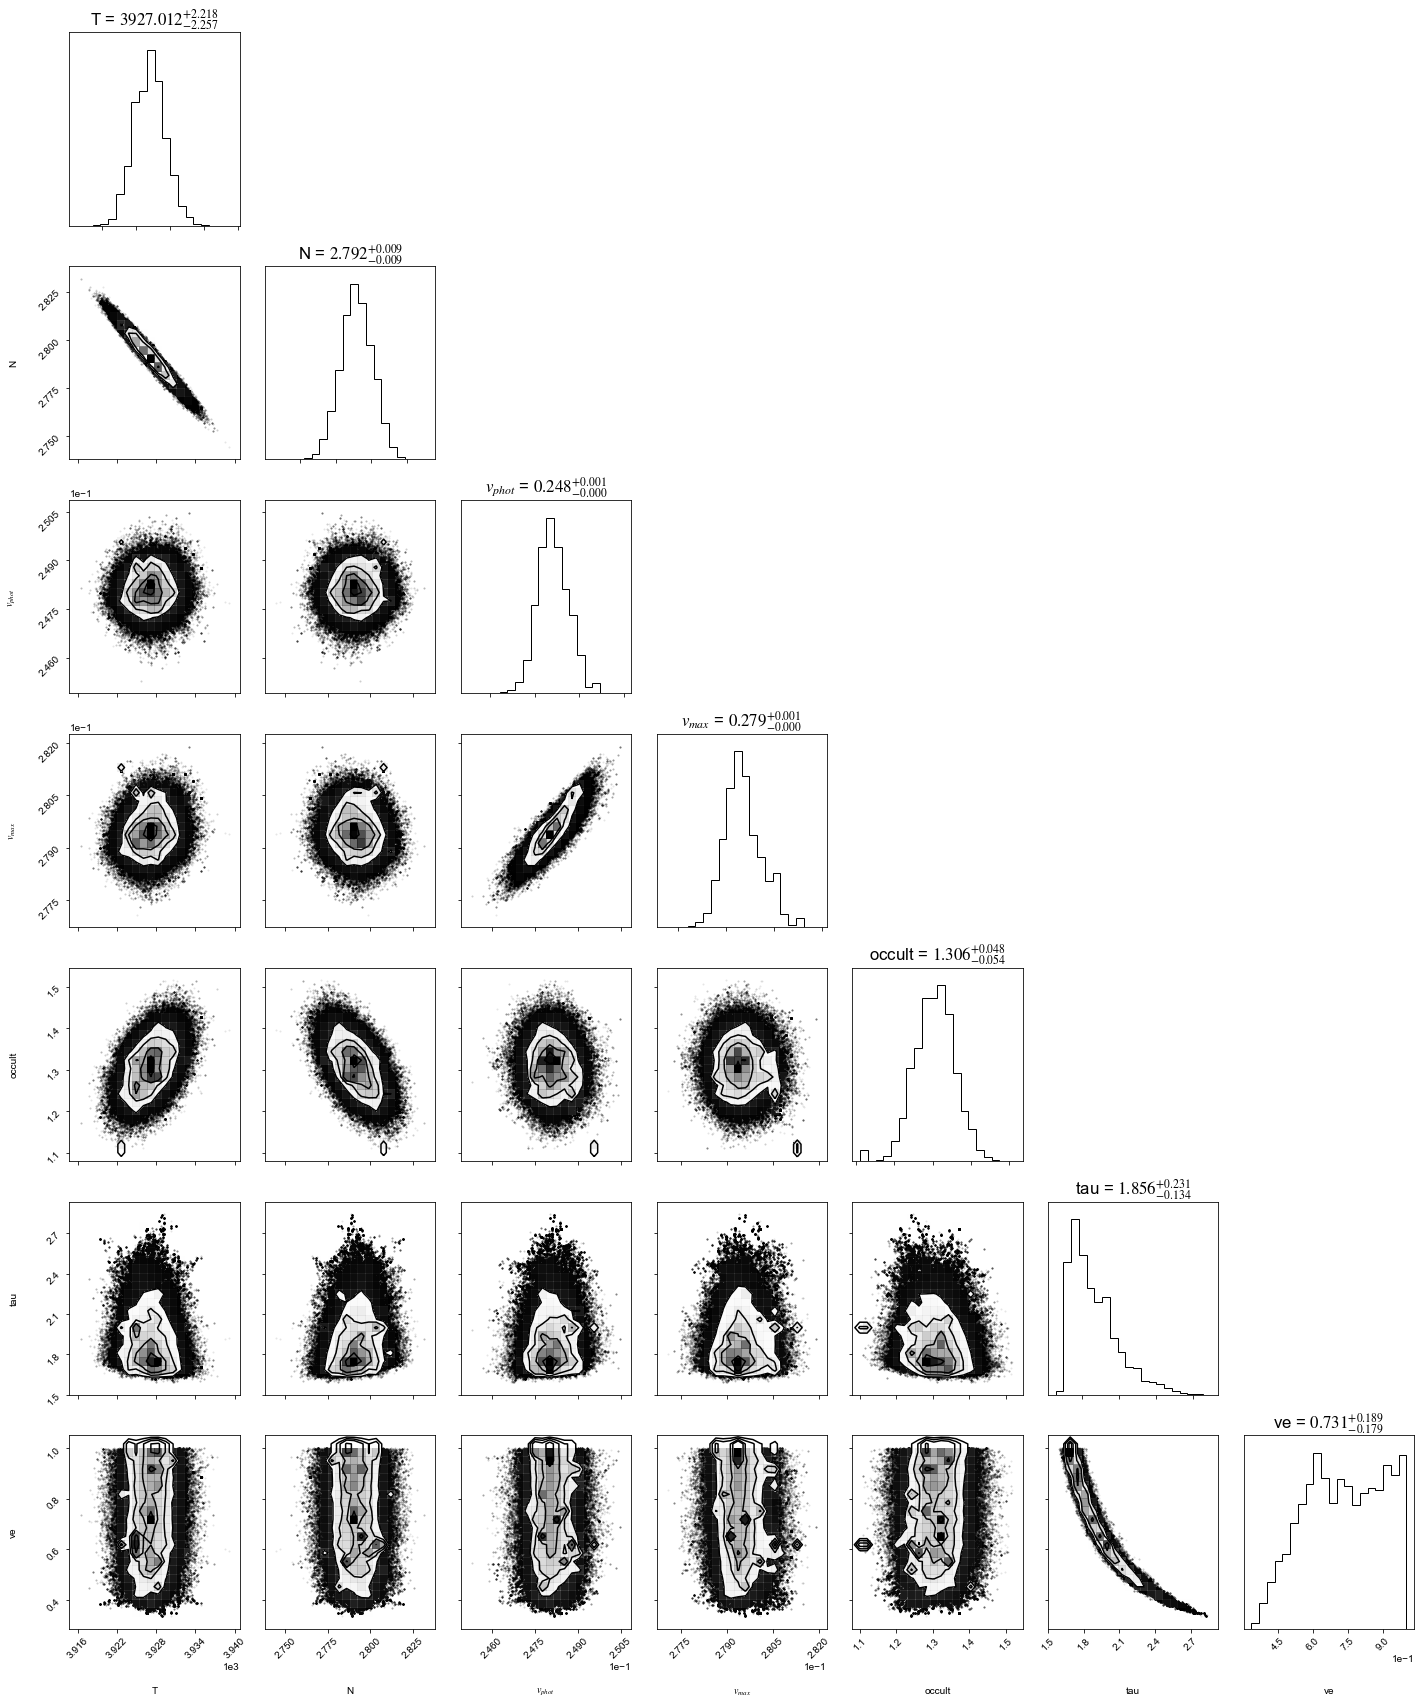

In [12]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'][25*1000:], flat['N'][25*1000:]*1e29, flat['vphot'][25*1000:], flat['vmax'][25*1000:], flat['occult'][25*1000:], flat['tau'][25*1000:], flat['ve'][25*1000:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB2_covariance_large_filtered_2.png', dpi=300)

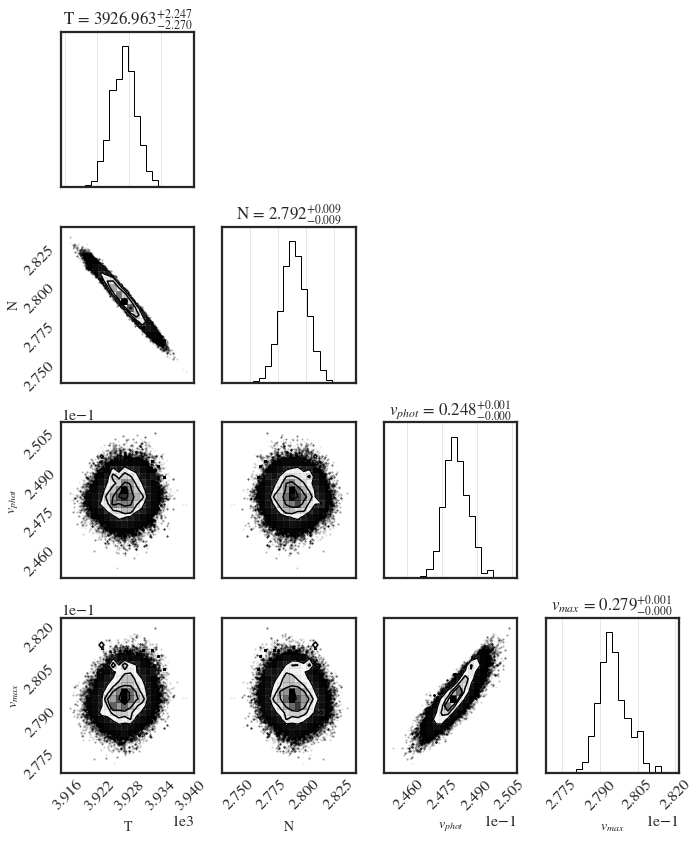

In [13]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

plt.savefig('Pictures/OB2_covariance_small_2.png', dpi=300)